## Reproduction of the UniformatBridge model implementation

- This is an **_unofficial_** reproduction of the experiment described in "Transformer language model for mapping construction schedule activities to uniformat categories" by Yoonhwa Jung, Julia Hockenmaier, and Mani Golparvar-Fard, 2024.
- The study can be accessed at https://doi.org/10.1016/j.autcon.2023.105183.

In [1]:
!python -V

Python 3.11.6


In [2]:
# 6p: "Five epochs with a batch size of 32, a dropout rate of 0.1, and a learning rate of 1.5e−5 were used to fine-tune the model."
epoch_size = 1#5
batch_size = 32
dropout_rate = 0.1  # BertForSequenceClassification default dropout_rate = 0.1
learning_rate = 1.5e-5

rseed = 42  # 7p: "In Table 2 and 3, 𝜇 is the average performance on three random seeds, and 𝜎 is their standard deviation."
dataset_path = "E:/_datasets/jung_et_al_2024/"  # Data should not be shared publicly.
experiment_name = 'with_prompt'

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Data

#### BIM and ASTM Uniformat categories

In [4]:
import pandas as pd
df = pd.read_excel(dataset_path+"0-overall-level3.xlsx", header=0)

cls = 'Level3'
df = df.loc[:, ['predwbs2', 'predwbs', 'predtask', 'wbs2', 'wbs', 'name', 'sucwbs2', 'sucwbs', 'suctask', cls]]

In [5]:
new_tokens = ['[pred]', '[succ]']

df['text'] = df.apply(
    lambda row: f"{row['predwbs2']} > {row['predwbs']} > {row['predtask']} [pred] {row['wbs2']} > {row['wbs']} > {row['name']} [succ] {row['sucwbs2']} > {row['sucwbs']} > {row['suctask']}",
    axis=1
)
df['label'] = df[cls]

print_idx = 6538  # D2040: 'Rain Water Drainage' case in Table 4
df['text'][print_idx], df['label'][print_idx]

('CONSTRUCTION SUPERSTRUCTURE > Roof > Set Mechanical Equipment [pred] CONSTRUCTION SUPERSTRUCTURE > Roof > Pipe Mechanical Equipment [succ]  100 KINGSHIGHWAY > COMMISSIONNG & INSPECTIONS > STARTUP',
 'D2040')

In [6]:
from sklearn.model_selection import train_test_split

texts = df['text']
labels = df['label']

# 6p: "This dataset is further split into training, validation, and testing using a 60-20-20 distribution."
train_texts, temp_texts, train_labels, temp_labels = train_test_split(texts, labels, test_size=0.4, random_state=rseed)
validation_texts, test_texts, validation_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=rseed)

(len(train_texts), len(validation_texts), len(test_texts))

(20469, 6823, 6824)

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [8]:
# import torch

# # Move to device
# train_labels_encoded = torch.tensor(encoded_labels[train_texts.index], dtype=torch.long).to(device)
# validation_labels_encoded = torch.tensor(encoded_labels[validation_texts.index], dtype=torch.long).to(device)
# test_labels_encoded = torch.tensor(encoded_labels[test_texts.index], dtype=torch.long).to(device)

### Tokenize

In [9]:
model_name = 'bert-base-uncased'

from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(set(encoded_labels))).to(device)

tokenizer.add_tokens(new_tokens)
model.resize_token_embeddings(len(tokenizer))

tokenizer, model

#### Tokenize a sequence of schedule activities (Texts)

In [ ]:
def encode(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)

encode(df['text'][print_idx])['input_ids']

tensor([[  101,  2810, 28391,  1028,  4412,  1028,  2275,  6228,  3941, 30522,
          2810, 28391,  1028,  4412,  1028,  8667,  6228,  3941, 30523,  2531,
          5465,  4048,  5603,  4576,  1028,  3222,  3070,  1004, 29589,  1028,
         22752,   102]])

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

def make_dataloader(plain_texts, encoded_labels, batch_size=32):
    '''
    plain_texts: list of strings (should be encoded when making dataloader due to tokenizer padding/truncation)
    encoded_labels: list of class indices (should be encoded beforehand using LabelEncoder with the entire dataset)
    '''
    texts = encode(plain_texts).to(device)
    labels = torch.tensor(encoded_labels, dtype=torch.long).to(device)
    dataset = TensorDataset(
        texts['input_ids'], 
        texts['attention_mask'], 
        labels,
    )
    return DataLoader(dataset, batch_size=batch_size)

train_labels_encoded = encoded_labels[train_texts.index]
validation_labels_encoded = encoded_labels[validation_texts.index]
test_labels_encoded = encoded_labels[test_texts.index]

train_loader = make_dataloader(train_texts.tolist(), train_labels_encoded, batch_size)
validation_loader = make_dataloader(validation_texts.tolist(), validation_labels_encoded, batch_size)
test_loader = make_dataloader(test_texts.tolist(), test_labels_encoded, batch_size)

torch.Size([20469, 148]) torch.Size([20469, 148]) torch.Size([20469])
torch.Size([6823, 147]) torch.Size([6823, 147]) torch.Size([6823])
torch.Size([6824, 150]) torch.Size([6824, 150]) torch.Size([6824])


In [ ]:
# # Move to device
# train_encodings = encode(train_texts.tolist()).to(device)
# validation_encodings = encode(validation_texts.tolist()).to(device)
# test_encodings = encode(test_texts.tolist()).to(device)

#### Make DataLoader (Texts & Labels)

In [ ]:
# from torch.utils.data import TensorDataset

# # attention_mask is 1 for real tokens and 0 for padding tokens
# train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels_encoded)
# validation_dataset = TensorDataset(validation_encodings['input_ids'], validation_encodings['attention_mask'], validation_labels_encoded)
# test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels_encoded)

In [ ]:
# from torch.utils.data import DataLoader

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### ★ Additional Datasets: ASTM Uniformat II Classification for Building Elements Description
- https://www.govinfo.gov/content/pkg/GOVPUB-C13-5af96252bc88826c911daac93c449927/pdf/GOVPUB-C13-5af96252bc88826c911daac93c449927.pdf

In [ ]:
# import pandas as pd

# # Publicly available definition of ASTM Uniformat II + CoT Prompt
# df_astm = pd.read_csv("public_astm_uniformat_ii_classification.csv", header=0)

# astm_labels = df_astm.apply(
#     lambda row: f"[{row['Class']}]",
#     axis=1
# )
# df_astm = df_astm[astm_labels.isin(label_encoder.classes_)] # Use only the classes that are in the dataset
# df_astm

#### ★ Additional Datasets: Data augmentation with GPT-2

In [ ]:
# from transformers import GPT2Tokenizer, GPT2LMHeadModel

# gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')

# def generate_with_gpt2(prompt_text, max_len=100, repetition_penalty=1.2):
#     inputs = gpt2_tokenizer.encode(prompt_text, return_tensors='pt')
#     outputs = gpt2_model.generate(
#         inputs, 
#         pad_token_id=gpt2_tokenizer.eos_token_id, 
#         max_length=max_len, 
#         # do_sample=True, temperature=0.9, # Probabilistic
#         repetition_penalty=repetition_penalty # Deterministic
#     )
#     generated_text = gpt2_tokenizer.decode(outputs[0])

#     return generated_text

# generate_with_gpt2("Once upon a time,")

In [ ]:
# # Intuition
# generate_with_gpt2("Examples of building structure components for services of plumbing and rain water drainage are")

In [ ]:
# def generate_with_gpt2_for_astm(level1, level2, level3):
#     prompt = f"Examples of building structure components for {level1.lower()} of {level2.lower()} and {level3.lower()} are"
#     return level1 + " " + level2 + " " + level3 + " " + repr(generate_with_gpt2(prompt)[len(prompt):])

# generate_with_gpt2_for_astm("SERVICES", "Plumbing", "Rain Water Drainage")  # D2040 in ASTM Uniformat

In [ ]:
# # astm_texts = df_astm.apply(
# #     lambda row: f"[pred] {generate_with_gpt2_for_astm(row['Level1'], row['Level2'], row['Level3'])} [succ]",
# #     axis=1
# # )


# # # Test # TODO: delete
# astm_texts = pd.concat([
#     pd.Series(100*["CONSTRUCTION SUPERSTRUCTURE > Roof > Set Mechanical Equipment [pred] CONSTRUCTION SUPERSTRUCTURE > Roof > Pipe Mechanical Equipment [succ]  100 KINGSHIGHWAY > COMMISSIONNG & INSPECTIONS > STARTUP"]),
#     pd.Series(100*["Garage Garage Structure | MEP FP | Finishes > LL1 > OH Sprinkler Piping Rough In LL1 [pred] Garage Garage Structure | MEP FP | Finishes > LL1 > OH Storm Drainage Piping Rough In LL1 [succ] Garage Garage Structure | MEP FP | Finishes > LL1 > Install Pipe Guards | Bollards LL1"]),
# ])
# astm_labels = pd.Series(["[D2040]"]*200)

# for i in range(5):
#     print(astm_texts[i], '...', astm_labels[i])

#### ★ Additional DataLoader from ASTM Uniformat class definition

In [ ]:
# astm_loader = make_dataloader(astm_texts.tolist(), label_encoder.transform(astm_labels.tolist()), batch_size)

#### Make DataLoader

In [ ]:
# from torch.utils.data import ConcatDataset

# merged_dataset = ConcatDataset([train_dataset, astm_dataset])
# merged_dataset = ConcatDataset([train_dataset, validation_dataset, test_dataset]) # For testing
# merged_loader = DataLoader(merged_dataset, batch_size=batch_size, shuffle=True)

# train_loader = merged_loader

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1.5e-05
    maximize: False
    weight_decay: 0
)

#### ★ Additional fine-tuning with publicly available ASTM Uniformat II classification

In [ ]:
# from tqdm import tqdm

# losses = []
# for epoch in tqdm(range(200)):
#     model.train()
#     total_loss = 0
#     for input_ids, attention_mask, labels in astm_loader:
#         model.zero_grad()
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss
#         total_loss += loss.item()
#         loss.backward()
#         optimizer.step()
#     losses.append(total_loss / len(astm_loader))

# import matplotlib.pyplot as plt
# plt.plot(losses)
# plt.title('Loss')
# plt.xlabel('Epoch')
# plt.show()

### Fine-tuning (Train & Validation)

100%|██████████| 640/640 [02:11<00:00,  4.85it/s]


Epoch 1 | Train Loss: 1.7982293508481235 | Validation Loss: 0.5864716092838305


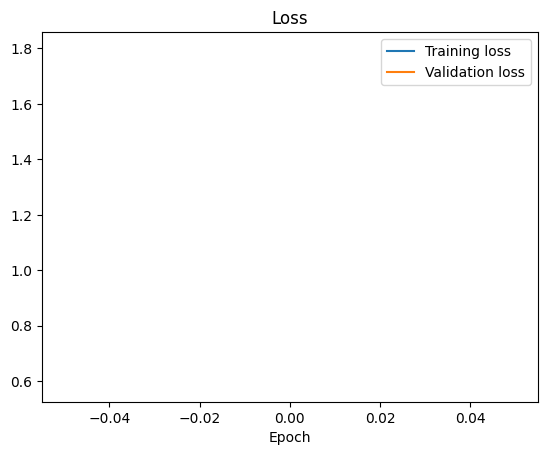

In [ ]:
from tqdm import tqdm

train_losses = []
val_losses = []
for epoch in range(epoch_size):
    model.train()
    train_loss = 0
    for input_ids, attention_mask, labels in tqdm(train_loader):
        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(train_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for input_ids, attention_mask, labels in validation_loader:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
            loss = outputs.loss
            val_loss += loss.item()
    val_losses.append(val_loss / len(validation_loader))
    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]} | Validation Loss: {val_losses[-1]}")

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

### Test

In [ ]:
model.eval()
with torch.no_grad():
    true_labels = []
    pred_labels = []
    df_test_rows = []
    for input_ids, attention_mask, labels in test_loader:
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        pred_labels.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        for b in range(input_ids.shape[0]):
            text = tokenizer.decode([token for i, token in enumerate(input_ids[b]) if attention_mask[b][i] == 1])
            pred_label = label_encoder.classes_[torch.argmax(outputs.logits[b]).item()]
            true_label = label_encoder.classes_[labels[b].item()]
            df_test_rows.append({'text': text, 'true_label': true_label, 'pred_label': pred_label, 'correct': pred_label == true_label})

# Data should not be shared publicly.
pd.DataFrame(df_test_rows).to_csv(dataset_path+f"/test_results_{experiment_name}.csv")

### Experimental Results

#### Overall Results

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy = accuracy_score(true_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(
    true_labels, 
    pred_labels, 
    # average='weighted', 
    average='macro',  # Original paper setting (page 8)
    zero_division=0
)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Accuracy: 0.8992
Precision: 0.5523
Recall: 0.5283
F1 Score: 0.5192


#### Class-wise Results

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average=None, zero_division=0)

class_names = label_encoder.inverse_transform(list(set(true_labels)))

performance_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})
performance_df.to_csv(f'experimental_results_rseed{rseed}_{experiment_name}.csv')
performance_df

,Class,Precision,Recall,F1 Score
0,[A1010],0.636364,0.940299,0.759036
1,[A1020],0.838710,0.852459,0.845528
2,[A1030],0.836364,0.647887,0.730159
3,[A2010],0.981132,0.702703,0.818898
4,[A2020],0.000000,0.000000,0.000000
5,[B1010],0.976631,0.996028,0.986234
6,[B1020],0.645833,0.946565,0.767802
7,[B2010],0.966312,0.985533,0.975828
8,[B2020],0.987879,1.000000,0.993902
9,[B2030],0.000000,0.000000,0.000000
